In [3]:
from utils import *
from fastai2.vision.widgets import *
from pathlib import Path

# League of Legends Champion Identifier #
The goal of this is to use deep learning to create an image classifier which can identify a League of Legends champion by using an image. The image classifier will be trained using 100 images of each of the currently existing League of Legends champions. After creating the classifier, we can test it by giving it images of the champion in different skins to see if the image classifier can actually use characteristics of the champion that it identified in the base 100 images (which may include some but not all of the skins of a champion) to identify the same champion in a different skin

## Gathering Data ##

In [2]:
bing_api_key = 'abc77f12e0fb42e1b15240f49dd9d8af'

### Obtaining the Current List of Champions ###
Navigate to https://na.leagueoflegends.com/en-us/champions/ and use BeautifulSoup to scrape the page. This will allow use to extract the current list of champion names.

In [3]:
import requests 
from bs4 import BeautifulSoup

<bound method Tag.prettify of <!DOCTYPE html>
<html data-riot-locale="en_US" data-riot-region="na" lang="en-us"><head><meta charset="utf-8"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/><script>try {
              document.documentElement.classList.add('js');

              var safari = /^((?!chrome|android).)*safari/i.test(window.navigator.userAgent);
              var ie11 = !!window.navigator.userAgent.match(/Trident.*rv:11./);
              var ie10 = !ie11 && (window.navigator.userAgent.indexOf('MSIE ') > -1);
              var edge = (window.navigator.userAgent.indexOf('Edge/') > -1);

              if (ie10 || ie11 || edge) document.documentElement.classList.add('is-ms');
              if (ie10 || ie11) document.documentElement.classList.add('is-ms-ie');
              if (ie10) document.documentElement.classList.add('is-ms-10');
              if (ie11) document.documentElement.classLi
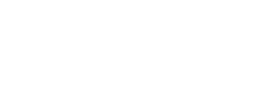

In [4]:
champions_url = "https://na.leagueoflegends.com/en-us/champions/"
champions_response = requests.get(champions_url)
champions_soup = BeautifulSoup(champions_response.content, "html.parser")
print(champions_soup.prettify)

Go within the structure of the page to extract the champion names. This will require searching for specific divs and spans, and this might need to be updated if the League of Legends champion list page is updated. 
We are going to find the container that stores all of the champions, get each of the champion containers from within it, and then extract the text from each champion container.

In [5]:
champions_container = champions_soup.find("div", attrs = {"class": "style__List-ntddd-2"})
champion_containers = champions_container.findChildren("a", recursive = False)
champions = list(map(lambda container: container.findChildren("span", attrs = {"class": "style__Text-sc-12h96bu-3"})[0].text, champion_containers))
print(champions)

['Aatrox', 'Ahri', 'Akali', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'Aurelion Sol', 'Azir', 'Bard', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', "Cho'Gath", 'Corki', 'Darius', 'Diana', 'Dr. Mundo', 'Draven', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'Fiddlesticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Hecarim', 'Heimerdinger', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'Jarvan IV', 'Jax', 'Jayce', 'Jhin', 'Jinx', "Kai'Sa", 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', "Kha'Zix", 'Kindred', 'Kled', "Kog'Maw", 'LeBlanc', 'Lee Sin', 'Leona', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'Master Yi', 'Miss Fortune', 'Mordekaiser', 'Morgana', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nocturne', 'Nunu & Willump', 'Olaf', 'Orianna', 'Ornn', 'Pantheon', 'Poppy', 'Pyke', 'Qiyana', 'Quinn', 'Rakan', 'Rammus', "Rek'Sai", 'Renekton', 'Rengar', 'Riven', 'Rum

### Gathering Images ###
We will use the Bing Image Search API to gather 100 images of each of the League of Legends champions.

In [5]:
path = Path("league_of_legends_champions")
if not path.exists():
    path.mkdir()
    for champion in champions:
        dest = (path/champion)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(bing_api_key, f'{champion} League of Legends')
        download_images(dest, urls=results.attrgot('content_url'))

Remove any failed images from the path. 

In [12]:
verify_images(get_image_files(path)).map(Path.unlink)

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be 

(#358) [None,None,None,None,None,None,None,None,None,None...]

## Creating and Training the Model ##
We will now use our downloaded data to create and train an image classifier model using deep learning.

### Creating DataLoader ###
We will use the data and DataBlocks to create an image DataLoader for our League of Legends champion images. In order to accomplish this, we will use a RandomSplitter to create validation data, RandomResizedCrop for our image transformations, and image augmentation for our batch transformations. The label of the image will be extracted from the name of its parent directory.

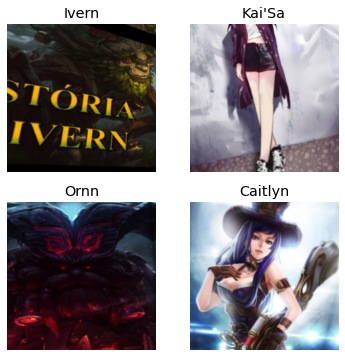

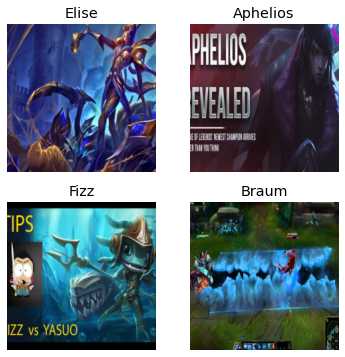

In [6]:
champions_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = champions_db.dataloaders(path)
dls.train.show_batch(max_n=4)
dls.valid.show_batch(max_n=4)

### Training the Model ###
We will train the model using the DataLoader, and then analyze and clean the data.

In [7]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,4.828220,3.509444,0.739762,02:00


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

epoch,train_loss,valid_loss,error_rate,time
0,3.568865,2.855912,0.616288,01:54
1,2.960569,2.417325,0.529284,01:53
2,2.413788,2.133208,0.468088,01:53
3,2.008709,1.973851,0.426518,01:54
4,1.820737,1.944376,0.416783,01:52


/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/I

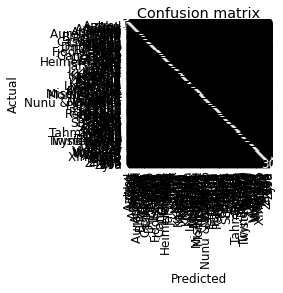

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

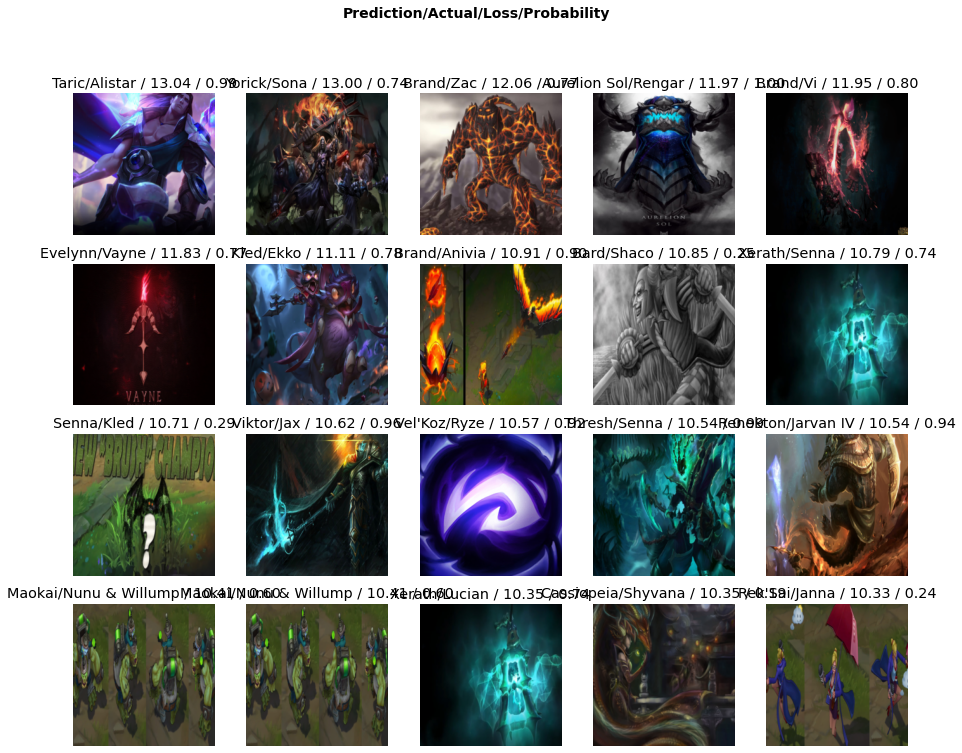

In [16]:
interp.plot_top_losses(20)

Cleaning the data doesn't seem to work - possibly because there is too much data. It definitely seems like the data is in need of cleaning though, since based on the top losses, there are definitely some poorly mapped images where the model was actually correct but was marked incorrect. 

In [ ]:
#cleaner = ImageClassifierCleaner(learn)
#cleaner

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:932: UserWarning: Palette images with Transpare

In [8]:
learn.export()